In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import uniform

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR

from sklearn.svm import LinearSVC, LinearSVR

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.decomposition import PCA

import io
from google.colab import files

import time




In [ ]:
excel_path = 'S&P 500 Index Dataset.xlsx'
df = pd.read_excel(excel_path, sheet_name=1, header=0, index_col=0, parse_dates=False)

df = df.dropna() #drop rows with NaN values

df['direction'] = (df['Close'].shift(-5)>df['Close']).astype(int)
print(df['direction'].value_counts())

1    5193
0    3800
Name: direction, dtype: int64


In [ ]:
df_train = df.iloc[:-100]
df_test = df.iloc[-100:]

In [ ]:
df = df_train

In [ ]:
df.shape

(8893, 135)

In [ ]:
sp_p = df[df['direction']==1]
sp_n = df[df['direction']==0]

feature_df = df.drop(columns = ['direction'])

X = np.asarray(feature_df) #independent

scaler = StandardScaler(copy=True, with_mean=True, with_std=True) #Standardise features and reduce dimensionality
df_scaled = scaler.fit_transform(X)
pca = PCA(n_components=20, random_state=1)
df_pca = pca.fit_transform(df_scaled)
df_pca.shape

X = np.asarray(df_pca)

y = np.asarray(df['direction']) #dependent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

svc = SVC(max_iter = -1, random_state = 1)
start=time.time()
svc.fit(X_train,y_train)
end=time.time()
print("Running Time:", end - start)
y_pred = svc.predict(X_test)

print(classification_report(y_test,y_pred))

#grid search

hyperparameters_svc = {'C' : [100], 'kernel' : ['poly']}

gs_svc = HalvingGridSearchCV(estimator= svc, param_grid=hyperparameters_svc, cv=10, scoring='accuracy', verbose=0, n_jobs=-1) #HalvingGridSearchCV if too long


Running Time: 1.9215893745422363
              precision    recall  f1-score   support

           0       0.62      0.12      0.20      1119
           1       0.60      0.95      0.73      1549

    accuracy                           0.60      2668
   macro avg       0.61      0.53      0.46      2668
weighted avg       0.61      0.60      0.51      2668



In [ ]:
gs_svc

HalvingGridSearchCV(cv=10, estimator=SVC(random_state=1), n_jobs=-1,
                    param_grid={'C': [100], 'kernel': ['poly']},
                    scoring='accuracy')

Running Time: 155.4174292087555
Accuracy on Cross Validation set : 0.6514056556543641
{'C': 100, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.59      0.42      0.49      1119
           1       0.65      0.79      0.71      1549

    accuracy                           0.63      2668
   macro avg       0.62      0.60      0.60      2668
weighted avg       0.63      0.63      0.62      2668



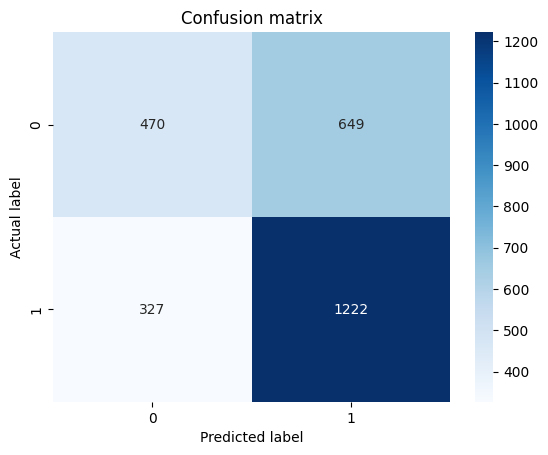

In [ ]:
start=time.time()
tuned_model_svc = gs_svc.fit(X_train, y_train)
end=time.time()
print("Running Time:", end - start)

best_accuracy = tuned_model_svc.best_score_
print('Accuracy on Cross Validation set :', best_accuracy)

best_parameters = tuned_model_svc.best_params_
print(best_parameters)

y_pred_svc = tuned_model_svc.predict(X_test)

print(classification_report(y_test, y_pred_svc))

#confusion matrix
c_mat = metrics.confusion_matrix(y_test, y_pred_svc)
TN = c_mat[0][0]
FN = c_mat[1][0]
TP = c_mat[1][1]
FP = c_mat[0][1]

fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_svc)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0','1'])
plt.show()

In [ ]:
feature_df = df_test.drop(columns = ['direction'])
X = np.asarray(feature_df) #independent
df_scaled = scaler.fit_transform(X)
pca = PCA(n_components=20, random_state=1)
df_pca = pca.fit_transform(df_scaled)
df_pca.shape

X = np.asarray(df_pca)
y = np.asarray(df_test['direction']) #dependent


              precision    recall  f1-score   support

           0       0.39      0.31      0.34        52
           1       0.39      0.48      0.43        48

    accuracy                           0.39       100
   macro avg       0.39      0.39      0.39       100
weighted avg       0.39      0.39      0.39       100



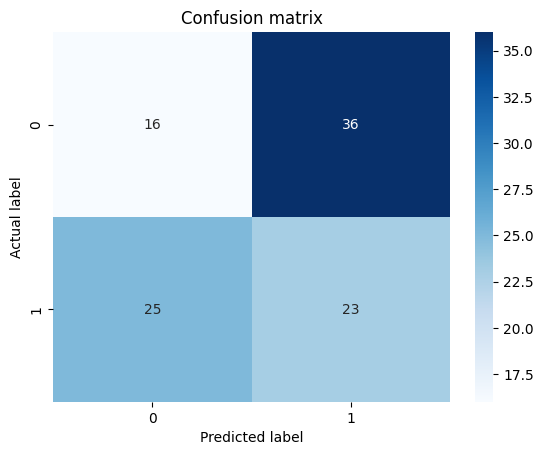

In [ ]:
y_pred_svc = tuned_model_svc.predict(X)

print(classification_report(y, y_pred_svc))

#confusion matrix
c_mat = metrics.confusion_matrix(y, y_pred_svc)
TN = c_mat[0][0]
FN = c_mat[1][0]
TP = c_mat[1][1]
FP = c_mat[0][1]

fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y, y_pred_svc)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0','1'])
plt.show()

In [ ]:
import json

arr = np.array(y_pred_svc)
list_to_save = arr.tolist()

with open('SVM_y_pred_list.json', 'w') as f:
    json.dump(list_to_save, f)

In [ ]:
y

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])